# Deep Learning - Assigment 1

### Group Number: 22

### Teammates:
1. **Mahshid Jafar Tajrishi**
2. **Bar Melinarskiy**
3. **Cis van Aken**
4. **Simon van Klompenburg**

## Imports entire notebook

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
from scipy.io import loadmat
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
torch.autograd.set_detect_anomaly(True)
from copy import deepcopy as dc
import random
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy.interpolate import interp1d

## Global Definitions

In [2]:
# Path to the zip file
data_dir = "./Data"
data_path = f"{data_dir}/Xtrain.mat"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

# Set a professional style for the plots
sns.set_theme(style="whitegrid")

model_name = "LSTM"
model_pth_path = f"best_model_{model_name}.pth"

In [3]:
# Check if CUDA is available
print(torch.__version__)
print(torch.version.cuda)  # Should match CUDA 12.5
print(torch.backends.cudnn.version())  # Should return a version, not None
print(torch.cuda.is_available())  # Should return True

2.5.1
None
90100
True


### Utilities 

In [4]:
def create_sequences(data, window_size, forecast_steps=1):
    X, y = [], []
    for i in range(len(data) - window_size - forecast_steps + 1):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size:i + window_size + forecast_steps, 0])
    X = np.array(X).reshape(-1, window_size, 1)
    y = np.array(y).reshape(-1, forecast_steps)
    return X, y

def prepare_dataloader(series, window_size, batch_size=16):
    """
    Preprocess the datasets for the transformer model.

    Args:
        series: Array of numbers with the sequence of the laser measurements.
        window_size: Integer, the sliding window size.
        batch_size: The number of samples used in one forward and backward pass through the network.

    Returns:
        DataLoader, X, y
    """
    X, y = create_sequences(series, window_size)
    # Ensure proper shapes: X → (N, seq_len, input_dim), y → (N, input_dim)
    X_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (N, seq_len, input_dim)
    y_tensor = torch.tensor(y, dtype=torch.float32)  # Shape: (N, input_dim)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False), X_tensor, y_tensor

def train_model(model, train_loader, val_loader, attempt_index, epochs=20, lr=1e-3, teacher_forcing_prob=0.6, patience=25):
    """
    Train the given model with validation and return the final validation L1 loss.
    Includes early stopping based on validation loss.
    Logs all metrics (L1, MSE, MAE) for each epoch into a DataFrame.
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    # Define loss functions
    huberLoss_criterion = nn.HuberLoss()  # Huber Loss
    mse_criterion = nn.MSELoss()  # MSE Loss
    mae_criterion = nn.L1Loss()  # MAE Loss (same as L1 Loss)

    best_val_loss = float('inf')
    best_model_state = model.state_dict()  # Initialize with the current model state
    no_improvement_epochs = 0  # Counter for early stopping

    # DataFrame to store metrics
    metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_l1", "train_mse", "train_mae", "val_l1", "val_mse", "val_mae"])

    # Progress bar for epochs
    epochs_pbar = tqdm(range(epochs), desc=f"Trial: {attempt_index}", unit="epoch")

    for epoch in epochs_pbar:
        # Training phase
        model.train()
        running_train_huberLoss_loss = 0.0
        running_train_mse_loss = 0.0
        running_train_mae_loss = 0.0

        for batch_index, batch in enumerate(train_loader):
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)

            # Forward pass
            output = model(x_batch)

            # Apply teacher forcing
            if random.random() < teacher_forcing_prob:
                x_batch = x_batch.clone()  # Avoid in-place modification
                x_batch[:, -1, 0] = y_batch[:, 0]

            # Calculate loss
            huberLoss_loss = huberLoss_criterion(output, y_batch)
            mse_loss = mse_criterion(output, y_batch)
            mae_loss = mae_criterion(output, y_batch)

            running_train_huberLoss_loss += huberLoss_loss.item()
            running_train_mse_loss += mse_loss.item()
            running_train_mae_loss += mae_loss.item()

            # Backward pass
            optimizer.zero_grad()
            mae_loss.backward()
            optimizer.step()

        avg_train_huberLoss_loss = running_train_huberLoss_loss / len(train_loader)
        avg_train_mse_loss = running_train_mse_loss / len(train_loader)
        avg_train_mae_loss = running_train_mae_loss / len(train_loader)

        # Validation phase
        model.eval()
        running_val_huberLoss_loss = 0.0
        running_val_mse_loss = 0.0
        running_val_mae_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                x_batch, y_batch = batch[0].to(device), batch[1].to(device)
                output = model(x_batch)

                huberLoss_loss = huberLoss_criterion(output, y_batch)
                mse_loss = mse_criterion(output, y_batch)
                mae_loss = mae_criterion(output, y_batch)

                running_val_huberLoss_loss += huberLoss_loss.item()
                running_val_mse_loss += mse_loss.item()
                running_val_mae_loss += mae_loss.item()

        avg_val_huberLoss_loss = running_val_huberLoss_loss / len(val_loader)
        avg_val_mse_loss = running_val_mse_loss / len(val_loader)
        avg_val_mae_loss = running_val_mae_loss / len(val_loader)

        # Save metrics to DataFrame
        new_row = pd.DataFrame([{
            "trial_id": attempt_index,
            "epoch": epoch + 1,
            "train_HuberLoss": avg_train_huberLoss_loss,
            "train_MSE": avg_train_mse_loss,
            "train_MAE": avg_train_mae_loss,
            "val_HuberLoss": avg_val_huberLoss_loss,
            "val_MSE": avg_val_mse_loss,
            "val_MAE": avg_val_mae_loss
        }])
        metrics_df = pd.concat([metrics_df, new_row], ignore_index=True)

        # Save the best model
        if avg_val_mae_loss < best_val_loss:
            best_val_loss = avg_val_mae_loss
            best_model_state = model.state_dict()
            no_improvement_epochs = 0  # Reset early stopping counter
        else:
            no_improvement_epochs += 1  # Increment early stopping counter

        # Early stopping
        if no_improvement_epochs >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break

        # Adjust learning rate
        scheduler.step()

        # Update progress bar
        epochs_pbar.set_postfix(
            Train_huberLoss_Loss=avg_train_huberLoss_loss,
            Train_MSE_Loss=avg_train_mse_loss,
            Train_MAE_Loss=avg_train_mae_loss,
            Val_huberLoss_Loss=avg_val_huberLoss_loss,
            Val_MSE_Loss=avg_val_mse_loss,
            Val_MAE_Loss=avg_val_mae_loss,
        )

    # Load the best model
    model.load_state_dict(best_model_state)

    return best_val_loss, metrics_df  # Return the best validation L1 loss and metrics DataFrame

### Long short-term memory (LSTM) RNN Model

In [5]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout=0.0) :
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True, dropout=dropout if num_stacked_layers > 1 else 0.0)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

### Load and Split the dataset into train-validation

In [6]:
# Define augmentation functions
def add_noise(x, std=0.002):
    return x + np.random.normal(0, std, size=x.shape)

def add_drift(x, strength=0.05):
    drift = np.linspace(0, strength, num=len(x)).reshape(-1, 1)
    return x + drift

def time_warp(x, stretch_factor=1.15):
    original_steps = np.arange(len(x))
    new_steps = np.linspace(0, len(x) - 1, int(len(x) * stretch_factor))
    warped = interp1d(original_steps, x.ravel(), kind='linear', fill_value="extrapolate")(new_steps)
    warped = warped[:len(x)]  # clip/pad to original size
    return warped.reshape(-1, 1)

# Define jittering function
def add_jitter(x, std=0.01):
    """
    Add small random perturbations (jitter) to the data.

    Args:
        x (np.ndarray): Input data.
        std (float): Standard deviation of the jitter.

    Returns:
        np.ndarray: Jittered data.
    """
    return x + np.random.normal(0, std, size=x.shape)

data = loadmat(data_path)
measurements = data['Xtrain']
# Check the shape of the data
print("Shape of measurements:", measurements.shape)

# Display the first few rows of the data
print(f"First 5 measurements: {measurements[:5]}")

print(f"measurements range: min={measurements.min()}, max={measurements.max()}")

# Creating sequences
max_window_size = 50  # Maximum window size
# Split data into training and validation sets
size_of_test = 200 + max_window_size  # 200 steps for testing + window size
train_data, val_data = measurements[:-size_of_test], measurements[-size_of_test:]

# Normalize the training data
scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data)

# Normalize the validation data using the same scaler
val_data_normalized = scaler.transform(val_data)

# Augment training data
print(f"Train shape before augmention: {train_data.shape}")

augmented = [train_data]  # 1x original

for _ in range(2):  # 2x noise
    augmented.append(add_noise(train_data))

# for _ in range(2):  # 2x drift
#     augmented.append(add_drift(train_data))

# for _ in range(2):  # 2x time warp
#     augmented.append(time_warp(train_data))

# for _ in range(2):  # 2x jittering
#     augmented.append(add_jitter(train_data))

train_augmented = np.vstack(augmented)
print("Augmented shape:", train_augmented.shape)

# Creating sequences
train_dataset, val_dataset = train_augmented, val_data_normalized

print(f"Train shape: {train_dataset.shape}, Val shape: {val_dataset.shape}")
print(f"train_dataset range: min={train_dataset.min()}, max={train_dataset.max()}")
print(f"val_dataset range: min={val_dataset.min()}, max={val_dataset.max()}")

Shape of measurements: (1000, 1)
First 5 measurements: [[ 86]
 [141]
 [ 95]
 [ 41]
 [ 22]]
measurements range: min=2, max=255
Train shape before augmention: (750, 1)
Augmented shape: (2250, 1)
Train shape: (2250, 1), Val shape: (250, 1)
train_dataset range: min=1.9984136107489416, max=255.00067246185526
val_dataset range: min=-0.9209486166007904, max=0.3992094861660078


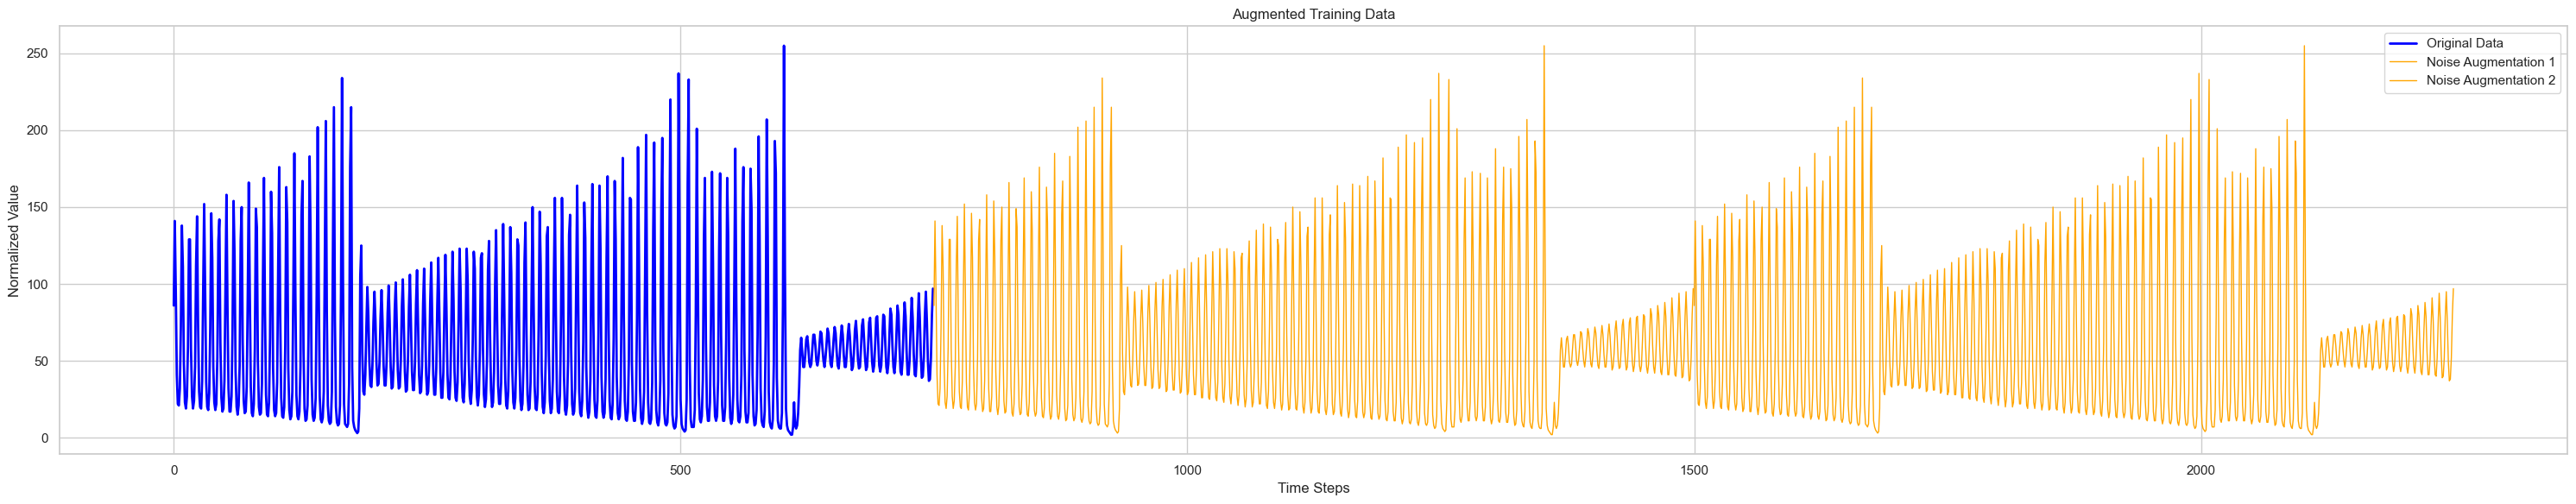

In [7]:
# Plot the train_dataset with different colors for each augmentation type
def plot_augmented_data(train_data, augmented_data, num_augmentations):
    plt.figure(figsize=(30, 6))
    
    # Plot the original data
    plt.plot(train_data, label="Original Data", color="blue", linewidth=2)
    
    # Plot the augmented data
    start_idx = len(train_data)
    for i in range(num_augmentations):
        end_idx = start_idx + len(train_data)
        if i < 2:
            label = f"Noise Augmentation {i + 1}"
            color = "orange"
        # elif i < 4:
        #     label = f"Drift Augmentation {i - 1}"
        #     color = "green"
        # elif i < 6:
        #     label = f"Time Warp Augmentation {i - 3}"
        #     color = "red"
        else:
            label = f"Jittering Augmentation {i - 5}"
            color = "purple"
        plt.plot(range(start_idx, end_idx), augmented_data[start_idx:end_idx], label=label, color=color, linewidth=1)
        start_idx = end_idx

    plt.xlabel("Time Steps")
    plt.ylabel("Normalized Value")
    plt.title("Augmented Training Data")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call the function to plot the data
plot_augmented_data(train_data, train_augmented, num_augmentations=2)

### Training the Model 

In [8]:
best_model = None

# Initialize a global DataFrame to store metrics for all trials
all_metrics_df = pd.DataFrame(columns=["trial_id", "epoch", "train_HuberLoss", "train_MSE", "train_MAE", "val_HuberLoss", "val_MSE", "val_MAE", 
                                       "hidden_size", "num_layers", "learning_rate", "batch_size", "window_size"])

def objective(trial):
    global all_metrics_df  # Use the global DataFrame to store metrics

    # Suggest hyperparameters
    hidden_size = trial.suggest_int('hidden_size', 32, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 1, 3)
    learning_rate = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64])
    window_size = trial.suggest_int('window_size', 5, 20, step=1)
    dropout = trial.suggest_float('dropout', 0.0, 0.4, step=0.1) 

    # Update data loaders with the suggested batch size
    train_loader, train_X, train_y = prepare_dataloader(train_dataset, window_size, batch_size=batch_size)
    val_loader, val_X, val_y = prepare_dataloader(val_dataset, window_size, batch_size=batch_size)

    # Define the model
    model = LSTM(
        input_size=1,  # Number of features in the input sequence
        hidden_size=hidden_size, # Number of features in the hidden state
        num_stacked_layers=num_layers, # Number of LSTM layers
        dropout=dropout  # Dropout rate
    ).to(device)

    # Train the model and get the final validation loss and metrics DataFrame
    trial_index = trial.number + 1  # Start from 1 for better readability in logs
    val_loss, metrics_df = train_model(
        model, train_loader, val_loader, attempt_index=trial_index, epochs=100, lr=learning_rate
    )

    # Add trial parameters to the metrics DataFrame
    metrics_df["hidden_size"] = hidden_size
    metrics_df["num_layers"] = num_layers
    metrics_df["learning_rate"] = learning_rate
    metrics_df["batch_size"] = batch_size
    metrics_df["window_size"] = window_size
    metrics_df["dropout"] = dropout  # Log the dropout value


    # Save the best model
    if trial.number == 0 or val_loss < study.best_value:
        torch.save(model.state_dict(), model_pth_path)
        print(f"Best model saved with trial {trial.number}")
        best_model = model

        # Save the best hyperparameters
        with open(f"best_hyperparameters_{model_name}.json", "w") as f:
            json.dump({
                "hidden_size": hidden_size,
                "num_layers": num_layers,
                "learning_rate": learning_rate,
                "batch_size": batch_size,
                "window_size": window_size,
                "dropout": dropout  
            }, f)

    # Append the metrics for this trial to the global DataFrame
    all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)

    return val_loss  # Optuna will minimize this


# Create a study object
study = optuna.create_study(direction="minimize")  # Minimize validation loss

# Optimize the objective function
study.optimize(objective, n_trials=100)  # Run 100 trials

# Save the combined metrics DataFrame to a CSV file
csv_path = f"all_trials_metrics_{model_name}.csv"
all_metrics_df.to_csv(csv_path, index=False)
print(f"All metrics saved to {csv_path}")

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Print the best validation loss
print("Best validation loss:", study.best_value)

# Load the best model
best_model = LSTM(
    input_size=1,
    hidden_size=study.best_params['hidden_size'],
    num_stacked_layers=study.best_params['num_layers']
).to(device)
best_model.load_state_dict(torch.load(f"best_model_{model_name}.pth"))
print("Best model loaded.")

# Update train_loader and val_loader with the best hyperparameters
train_loader, train_X, train_y = prepare_dataloader(train_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
val_loader, val_X, val_y = prepare_dataloader(val_dataset, study.best_params['window_size'], batch_size=study.best_params['batch_size'])
print("Data loaders updated with best hyperparameters.")

[I 2025-05-07 14:32:41,788] A new study created in memory with name: no-name-13719e7b-87e7-423d-b683-99c015c7be0a


Trial: 1:   0%|          | 0/100 [00:00<?, ?epoch/s]

C:\Users\bar24\AppData\Local\Temp\ipykernel_33320\3447311338.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_metrics_df = pd.concat([all_metrics_df, metrics_df], ignore_index=True)
[I 2025-05-07 14:33:08,105] Trial 0 finished with value: 1.403374046087265 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.000765086330493613, 'batch_size': 32, 'window_size': 17, 'dropout': 0.1}. Best is trial 0 with value: 1.403374046087265.


Early stopping triggered after 26 epochs.
Best model saved with trial 0


Trial: 2:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:33:20,694] Trial 1 finished with value: 0.551400899887085 and parameters: {'hidden_size': 32, 'num_layers': 1, 'lr': 6.205888147404647e-05, 'batch_size': 64, 'window_size': 16, 'dropout': 0.0}. Best is trial 1 with value: 0.551400899887085.


Early stopping triggered after 26 epochs.
Best model saved with trial 1


Trial: 3:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:33:45,524] Trial 2 finished with value: 0.5075850673019886 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.0001451721818338747, 'batch_size': 32, 'window_size': 10, 'dropout': 0.1}. Best is trial 2 with value: 0.5075850673019886.


Early stopping triggered after 26 epochs.
Best model saved with trial 2


Trial: 4:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:34:02,585] Trial 3 finished with value: 18.149492263793945 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.001523529403452131, 'batch_size': 64, 'window_size': 17, 'dropout': 0.1}. Best is trial 2 with value: 0.5075850673019886.


Early stopping triggered after 26 epochs.


Trial: 5:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:34:27,579] Trial 4 finished with value: 0.6829031333327293 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 7.7217658655373e-05, 'batch_size': 32, 'window_size': 17, 'dropout': 0.2}. Best is trial 2 with value: 0.5075850673019886.


Early stopping triggered after 26 epochs.


Trial: 6:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:34:41,600] Trial 5 finished with value: 0.535566970705986 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 2.530046384845844e-05, 'batch_size': 64, 'window_size': 6, 'dropout': 0.4}. Best is trial 2 with value: 0.5075850673019886.


Early stopping triggered after 26 epochs.


Trial: 7:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:34:54,861] Trial 6 finished with value: 0.6059082746505737 and parameters: {'hidden_size': 96, 'num_layers': 3, 'lr': 3.331346147503482e-05, 'batch_size': 64, 'window_size': 20, 'dropout': 0.0}. Best is trial 2 with value: 0.5075850673019886.


Early stopping triggered after 26 epochs.


Trial: 8:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:35:43,339] Trial 7 finished with value: 0.303609199821949 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.007532116492636542, 'batch_size': 32, 'window_size': 5, 'dropout': 0.30000000000000004}. Best is trial 7 with value: 0.303609199821949.


Early stopping triggered after 49 epochs.
Best model saved with trial 7


Trial: 9:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:36:15,105] Trial 8 finished with value: 0.501679502427578 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.00031562172582402337, 'batch_size': 64, 'window_size': 17, 'dropout': 0.2}. Best is trial 7 with value: 0.303609199821949.


Early stopping triggered after 62 epochs.


Trial: 10:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:36:43,098] Trial 9 finished with value: 0.6498513668775558 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 1.2876678326167634e-05, 'batch_size': 32, 'window_size': 6, 'dropout': 0.0}. Best is trial 7 with value: 0.303609199821949.


Early stopping triggered after 26 epochs.


Trial: 11:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:37:16,959] Trial 10 finished with value: 46.54242658615112 and parameters: {'hidden_size': 256, 'num_layers': 2, 'lr': 0.006811439941797154, 'batch_size': 32, 'window_size': 10, 'dropout': 0.4}. Best is trial 7 with value: 0.303609199821949.


Early stopping triggered after 35 epochs.


Trial: 12:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:37:43,473] Trial 11 finished with value: 0.7098563387989998 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.007589346983109481, 'batch_size': 64, 'window_size': 13, 'dropout': 0.30000000000000004}. Best is trial 7 with value: 0.303609199821949.


Early stopping triggered after 53 epochs.


Trial: 13:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:37:57,996] Trial 12 finished with value: 0.5252372846007347 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.0004080078802160369, 'batch_size': 64, 'window_size': 13, 'dropout': 0.30000000000000004}. Best is trial 7 with value: 0.303609199821949.


Early stopping triggered after 26 epochs.


Trial: 14:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:38:39,908] Trial 13 finished with value: 0.5222753286361694 and parameters: {'hidden_size': 256, 'num_layers': 1, 'lr': 0.0024492123615478647, 'batch_size': 32, 'window_size': 9, 'dropout': 0.30000000000000004}. Best is trial 7 with value: 0.303609199821949.


Early stopping triggered after 43 epochs.


Trial: 15:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:39:02,926] Trial 14 finished with value: 0.6852634772658348 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0002399236921773681, 'batch_size': 32, 'window_size': 20, 'dropout': 0.2}. Best is trial 7 with value: 0.303609199821949.


Early stopping triggered after 26 epochs.


Trial: 16:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:39:22,399] Trial 15 finished with value: 1.45127671957016 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.0018921806346041564, 'batch_size': 64, 'window_size': 5, 'dropout': 0.30000000000000004}. Best is trial 7 with value: 0.303609199821949.


Early stopping triggered after 42 epochs.


Trial: 17:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:39:50,925] Trial 16 finished with value: 14.78456962108612 and parameters: {'hidden_size': 224, 'num_layers': 3, 'lr': 0.0006486875190998017, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2}. Best is trial 7 with value: 0.303609199821949.


Early stopping triggered after 26 epochs.


Trial: 18:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:40:03,463] Trial 17 finished with value: 22.7952241897583 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.004304089897704484, 'batch_size': 64, 'window_size': 15, 'dropout': 0.4}. Best is trial 7 with value: 0.303609199821949.


Early stopping triggered after 26 epochs.


Trial: 19:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:40:16,271] Trial 18 finished with value: 0.5943033397197723 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.00018974004572132875, 'batch_size': 64, 'window_size': 11, 'dropout': 0.2}. Best is trial 7 with value: 0.303609199821949.


Early stopping triggered after 26 epochs.


Trial: 20:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:41:00,937] Trial 19 finished with value: 0.9236222207546234 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0008447318575286995, 'batch_size': 32, 'window_size': 14, 'dropout': 0.30000000000000004}. Best is trial 7 with value: 0.303609199821949.


Early stopping triggered after 42 epochs.


Trial: 21:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:41:21,280] Trial 20 finished with value: 7.742286801338196 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.00042906513758636945, 'batch_size': 64, 'window_size': 19, 'dropout': 0.2}. Best is trial 7 with value: 0.303609199821949.


Early stopping triggered after 26 epochs.


Trial: 22:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:42:38,312] Trial 21 finished with value: 0.3611561916768551 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.00011840313483141796, 'batch_size': 32, 'window_size': 8, 'dropout': 0.1}. Best is trial 7 with value: 0.303609199821949.


Early stopping triggered after 86 epochs.


Trial: 23:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:43:00,388] Trial 22 finished with value: 0.6127554476261139 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 9.821685092378502e-05, 'batch_size': 32, 'window_size': 7, 'dropout': 0.1}. Best is trial 7 with value: 0.303609199821949.


Early stopping triggered after 26 epochs.


Trial: 24:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:43:22,766] Trial 23 finished with value: 0.5682926252484322 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.0002682056945119144, 'batch_size': 32, 'window_size': 5, 'dropout': 0.1}. Best is trial 7 with value: 0.303609199821949.


Early stopping triggered after 26 epochs.


Trial: 25:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:43:44,963] Trial 24 finished with value: 0.5827773362398148 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 4.563687714062699e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2}. Best is trial 7 with value: 0.303609199821949.


Early stopping triggered after 26 epochs.


Trial: 26:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:44:32,450] Trial 25 finished with value: 0.28867789171636105 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.00011156477300258033, 'batch_size': 32, 'window_size': 7, 'dropout': 0.1}. Best is trial 25 with value: 0.28867789171636105.


Early stopping triggered after 48 epochs.
Best model saved with trial 25


Trial: 27:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:45:36,946] Trial 26 finished with value: 0.27185627073049545 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.00011995892926538096, 'batch_size': 32, 'window_size': 8, 'dropout': 0.1}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 66 epochs.
Best model saved with trial 26


Trial: 28:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:46:01,969] Trial 27 finished with value: 0.6648251935839653 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 1.1706197649297863e-05, 'batch_size': 32, 'window_size': 6, 'dropout': 0.0}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 29:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:46:28,445] Trial 28 finished with value: 0.5949806421995163 and parameters: {'hidden_size': 224, 'num_layers': 2, 'lr': 2.4454893402451072e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.1}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 30:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:47:15,721] Trial 29 finished with value: 2.348671942949295 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.0007850728227557534, 'batch_size': 32, 'window_size': 7, 'dropout': 0.0}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 48 epochs.


Trial: 31:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:47:43,457] Trial 30 finished with value: 31.25455355644226 and parameters: {'hidden_size': 128, 'num_layers': 3, 'lr': 0.0035039992489489425, 'batch_size': 32, 'window_size': 5, 'dropout': 0.1}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 32:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:48:09,965] Trial 31 finished with value: 0.6932917907834053 and parameters: {'hidden_size': 64, 'num_layers': 2, 'lr': 0.00011254945560514086, 'batch_size': 32, 'window_size': 7, 'dropout': 0.1}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 33:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:48:35,114] Trial 32 finished with value: 0.6225995793938637 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 5.779063294825059e-05, 'batch_size': 32, 'window_size': 9, 'dropout': 0.1}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 34:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:48:58,936] Trial 33 finished with value: 0.4920932427048683 and parameters: {'hidden_size': 32, 'num_layers': 2, 'lr': 0.00015996492687079202, 'batch_size': 32, 'window_size': 8, 'dropout': 0.1}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 35:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:50:36,421] Trial 34 finished with value: 0.33085052482783794 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.00011318163102432067, 'batch_size': 32, 'window_size': 9, 'dropout': 0.0}. Best is trial 26 with value: 0.27185627073049545.


Trial: 36:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:51:00,723] Trial 35 finished with value: 0.5028734467923641 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 6.70946354958631e-05, 'batch_size': 32, 'window_size': 11, 'dropout': 0.0}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 37:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:51:28,194] Trial 36 finished with value: 0.5570918098092079 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 4.2312478978616044e-05, 'batch_size': 32, 'window_size': 9, 'dropout': 0.0}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 38:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:51:50,949] Trial 37 finished with value: 0.5636477991938591 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 8.804757082630275e-05, 'batch_size': 32, 'window_size': 6, 'dropout': 0.0}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 39:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:52:14,537] Trial 38 finished with value: 0.8052669391036034 and parameters: {'hidden_size': 128, 'num_layers': 2, 'lr': 0.00016615570143232482, 'batch_size': 32, 'window_size': 10, 'dropout': 0.0}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 40:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:52:41,358] Trial 39 finished with value: 0.6078711077570915 and parameters: {'hidden_size': 160, 'num_layers': 3, 'lr': 2.595671085458287e-05, 'batch_size': 32, 'window_size': 7, 'dropout': 0.0}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 41:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:53:39,635] Trial 40 finished with value: 1.2953483909368515 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 0.0011498124590854984, 'batch_size': 32, 'window_size': 10, 'dropout': 0.2}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 62 epochs.


Trial: 42:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:54:34,326] Trial 41 finished with value: 0.3439082130789757 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.00012993530263236255, 'batch_size': 32, 'window_size': 8, 'dropout': 0.1}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 64 epochs.


Trial: 43:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:54:56,183] Trial 42 finished with value: 0.5603274628520012 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.00020743373510459908, 'batch_size': 32, 'window_size': 6, 'dropout': 0.1}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 44:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:55:52,549] Trial 43 finished with value: 0.34881966561079025 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 0.0003836280296555391, 'batch_size': 32, 'window_size': 9, 'dropout': 0.1}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 66 epochs.


Trial: 45:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:56:14,274] Trial 44 finished with value: 0.6446551606059074 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.00012018015007260939, 'batch_size': 32, 'window_size': 7, 'dropout': 0.4}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 46:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:57:27,944] Trial 45 finished with value: 0.4385906271636486 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 7.648520481149449e-05, 'batch_size': 32, 'window_size': 12, 'dropout': 0.2}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 86 epochs.


Trial: 47:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:57:49,590] Trial 46 finished with value: 0.5711205676198006 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.00014308615585278752, 'batch_size': 32, 'window_size': 5, 'dropout': 0.1}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 48:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:58:13,465] Trial 47 finished with value: 0.42108600214123726 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.0005938828778027066, 'batch_size': 32, 'window_size': 6, 'dropout': 0.30000000000000004}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 28 epochs.


Trial: 49:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:58:40,022] Trial 48 finished with value: 0.576772578060627 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 1.7254723499773344e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.0}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 50:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:59:05,117] Trial 49 finished with value: 0.5766635239124298 and parameters: {'hidden_size': 96, 'num_layers': 2, 'lr': 5.78938243798284e-05, 'batch_size': 32, 'window_size': 9, 'dropout': 0.2}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 51:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 14:59:27,027] Trial 50 finished with value: 0.6724645420908928 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.00028975246062190536, 'batch_size': 32, 'window_size': 6, 'dropout': 0.1}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 52:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:00:23,383] Trial 51 finished with value: 0.33495015278458595 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 0.0003416064246735921, 'batch_size': 32, 'window_size': 10, 'dropout': 0.1}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 67 epochs.


Trial: 53:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:00:46,925] Trial 52 finished with value: 0.7803593277931213 and parameters: {'hidden_size': 32, 'num_layers': 1, 'lr': 0.005449080377424893, 'batch_size': 32, 'window_size': 12, 'dropout': 0.1}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 29 epochs.


Trial: 54:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:01:23,501] Trial 53 finished with value: 0.6446403935551643 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 4.1515758374150924e-05, 'batch_size': 32, 'window_size': 10, 'dropout': 0.1}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 42 epochs.


Trial: 55:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:01:34,664] Trial 54 finished with value: 0.5882983654737473 and parameters: {'hidden_size': 96, 'num_layers': 1, 'lr': 0.00021204181618305292, 'batch_size': 64, 'window_size': 8, 'dropout': 0.2}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 56:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:01:59,135] Trial 55 finished with value: 0.43779170885682106 and parameters: {'hidden_size': 64, 'num_layers': 1, 'lr': 0.002295500640623636, 'batch_size': 32, 'window_size': 9, 'dropout': 0.1}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 28 epochs.


Trial: 57:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:02:41,567] Trial 56 finished with value: 0.5143004283308983 and parameters: {'hidden_size': 32, 'num_layers': 1, 'lr': 0.0012994000035704454, 'batch_size': 32, 'window_size': 7, 'dropout': 0.30000000000000004}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 49 epochs.


Trial: 58:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:02:54,853] Trial 57 finished with value: 0.5912543684244156 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 9.784228976721961e-05, 'batch_size': 64, 'window_size': 10, 'dropout': 0.0}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 59:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:03:30,139] Trial 58 finished with value: 0.4291527681052685 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.0005354615857399266, 'batch_size': 32, 'window_size': 11, 'dropout': 0.4}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 41 epochs.


Trial: 60:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:04:30,511] Trial 59 finished with value: 0.34109026193618774 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.00013424201068807303, 'batch_size': 32, 'window_size': 8, 'dropout': 0.2}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 67 epochs.


Trial: 61:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:04:59,481] Trial 60 finished with value: 3.9146884083747864 and parameters: {'hidden_size': 192, 'num_layers': 3, 'lr': 0.0003134915051187522, 'batch_size': 32, 'window_size': 5, 'dropout': 0.2}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 26 epochs.


Trial: 62:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:06:08,581] Trial 61 finished with value: 0.282544719055295 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.00012809628774653394, 'batch_size': 32, 'window_size': 8, 'dropout': 0.30000000000000004}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 81 epochs.


Trial: 63:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:07:03,626] Trial 62 finished with value: 0.2876413967460394 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 8.227568499395574e-05, 'batch_size': 32, 'window_size': 7, 'dropout': 0.30000000000000004}. Best is trial 26 with value: 0.27185627073049545.


Early stopping triggered after 63 epochs.


Trial: 64:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:07:35,673] Trial 63 finished with value: 0.20566110126674175 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.009628567875222536, 'batch_size': 32, 'window_size': 7, 'dropout': 0.30000000000000004}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 31 epochs.
Best model saved with trial 63


Trial: 65:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:08:23,569] Trial 64 finished with value: 0.8554419130086899 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.007634939993318952, 'batch_size': 32, 'window_size': 7, 'dropout': 0.30000000000000004}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 48 epochs.


Trial: 66:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:08:49,494] Trial 65 finished with value: 0.9841417744755745 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.00571266410658194, 'batch_size': 32, 'window_size': 6, 'dropout': 0.30000000000000004}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 29 epochs.


Trial: 67:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:09:03,123] Trial 66 finished with value: 42.17099857330322 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 0.009483260983288227, 'batch_size': 64, 'window_size': 7, 'dropout': 0.30000000000000004}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 26 epochs.


Trial: 68:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:09:29,884] Trial 67 finished with value: 1.7480646967887878 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.0032763104326472667, 'batch_size': 32, 'window_size': 6, 'dropout': 0.30000000000000004}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 28 epochs.


Trial: 69:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:10:08,165] Trial 68 finished with value: 0.6811288446187973 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 0.00997190101075708, 'batch_size': 32, 'window_size': 9, 'dropout': 0.30000000000000004}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 41 epochs.


Trial: 70:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:10:33,508] Trial 69 finished with value: 0.6212175264954567 and parameters: {'hidden_size': 160, 'num_layers': 2, 'lr': 7.763641456414706e-05, 'batch_size': 32, 'window_size': 5, 'dropout': 0.30000000000000004}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 26 epochs.


Trial: 71:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:10:57,483] Trial 70 finished with value: 0.5684209987521172 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 5.0658046752569e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 26 epochs.


Trial: 72:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:11:41,572] Trial 71 finished with value: 0.29488380439579487 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.00017623145470539224, 'batch_size': 32, 'window_size': 7, 'dropout': 0.30000000000000004}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 43 epochs.


Trial: 73:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:12:20,127] Trial 72 finished with value: 0.3049272019416094 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.00017609678481007396, 'batch_size': 32, 'window_size': 7, 'dropout': 0.30000000000000004}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 43 epochs.


Trial: 74:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:12:58,301] Trial 73 finished with value: 0.3126596976071596 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.0001854024744153413, 'batch_size': 32, 'window_size': 7, 'dropout': 0.30000000000000004}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 41 epochs.


Trial: 75:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:14:30,009] Trial 74 finished with value: 0.38560546189546585 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 9.496483492557278e-05, 'batch_size': 32, 'window_size': 18, 'dropout': 0.30000000000000004}. Best is trial 63 with value: 0.20566110126674175.


Trial: 76:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:14:52,065] Trial 75 finished with value: 0.6018406897783279 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.00023671929115535043, 'batch_size': 32, 'window_size': 6, 'dropout': 0.30000000000000004}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 26 epochs.


Trial: 77:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:15:13,797] Trial 76 finished with value: 0.6014963015913963 and parameters: {'hidden_size': 224, 'num_layers': 1, 'lr': 0.00016792381495616107, 'batch_size': 32, 'window_size': 5, 'dropout': 0.30000000000000004}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 26 epochs.


Trial: 78:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:15:39,987] Trial 77 finished with value: 0.5399706847965717 and parameters: {'hidden_size': 192, 'num_layers': 2, 'lr': 3.233883828775103e-05, 'batch_size': 32, 'window_size': 16, 'dropout': 0.30000000000000004}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 26 epochs.


Trial: 79:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:15:55,171] Trial 78 finished with value: 0.5494864881038666 and parameters: {'hidden_size': 256, 'num_layers': 3, 'lr': 6.547681811553033e-05, 'batch_size': 64, 'window_size': 7, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 26 epochs.


Trial: 80:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:16:30,734] Trial 79 finished with value: 0.39249974861741066 and parameters: {'hidden_size': 192, 'num_layers': 1, 'lr': 0.00025491176407984613, 'batch_size': 32, 'window_size': 8, 'dropout': 0.30000000000000004}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 42 epochs.


Trial: 81:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:17:24,928] Trial 80 finished with value: 0.29086688347160816 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 8.296829545150477e-05, 'batch_size': 32, 'window_size': 7, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 63 epochs.


Trial: 82:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:18:16,813] Trial 81 finished with value: 0.2877397183328867 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 7.417819117972234e-05, 'batch_size': 32, 'window_size': 7, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 64 epochs.


Trial: 83:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:18:38,829] Trial 82 finished with value: 0.6007318273186684 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 7.822943611641338e-05, 'batch_size': 32, 'window_size': 6, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 26 epochs.


Trial: 84:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:19:21,696] Trial 83 finished with value: 0.28866591677069664 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.00010517840185944607, 'batch_size': 32, 'window_size': 7, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 49 epochs.


Trial: 85:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:20:08,140] Trial 84 finished with value: 0.2895245607942343 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.0001065392054543984, 'batch_size': 32, 'window_size': 7, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 49 epochs.


Trial: 86:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:20:32,763] Trial 85 finished with value: 0.5167501233518124 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 5.0076207286824695e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 27 epochs.


Trial: 87:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:21:15,856] Trial 86 finished with value: 0.29550919122993946 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.00010491474081234736, 'batch_size': 32, 'window_size': 7, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 50 epochs.


Trial: 88:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:21:37,985] Trial 87 finished with value: 0.5284518450498581 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 6.350116330606974e-05, 'batch_size': 32, 'window_size': 6, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 26 epochs.


Trial: 89:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:22:48,897] Trial 88 finished with value: 0.3240520544350147 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 8.286955811486186e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 82 epochs.


Trial: 90:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:23:49,060] Trial 89 finished with value: 0.40689991414546967 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.0001242784135162992, 'batch_size': 32, 'window_size': 9, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 69 epochs.


Trial: 91:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:24:12,279] Trial 90 finished with value: 0.5670946054160595 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.00015021633174368385, 'batch_size': 32, 'window_size': 14, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 26 epochs.


Trial: 92:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:25:07,605] Trial 91 finished with value: 0.2866030987352133 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.00010628320215794231, 'batch_size': 32, 'window_size': 7, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 62 epochs.


Trial: 93:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:25:31,633] Trial 92 finished with value: 0.6004851534962654 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 7.051476663561245e-05, 'batch_size': 32, 'window_size': 7, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 26 epochs.


Trial: 94:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:26:13,753] Trial 93 finished with value: 0.32882654666900635 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.00010722485540526951, 'batch_size': 32, 'window_size': 8, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 52 epochs.


Trial: 95:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:26:34,072] Trial 94 finished with value: 0.5138131566345692 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 3.894302230051808e-05, 'batch_size': 32, 'window_size': 7, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 26 epochs.


Trial: 96:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:26:55,667] Trial 95 finished with value: 0.5037586763501167 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 9.768320855054034e-05, 'batch_size': 32, 'window_size': 6, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 26 epochs.


Trial: 97:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:27:20,984] Trial 96 finished with value: 0.5691554769873619 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 5.612390217300132e-05, 'batch_size': 32, 'window_size': 8, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 28 epochs.


Trial: 98:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:27:44,976] Trial 97 finished with value: 0.6101944968104362 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 8.680884919302349e-05, 'batch_size': 32, 'window_size': 6, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 26 epochs.


Trial: 99:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:28:10,143] Trial 98 finished with value: 0.6083177998661995 and parameters: {'hidden_size': 128, 'num_layers': 1, 'lr': 3.389023460966421e-05, 'batch_size': 32, 'window_size': 7, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 26 epochs.


Trial: 100:   0%|          | 0/100 [00:00<?, ?epoch/s]

[I 2025-05-07 15:28:22,373] Trial 99 finished with value: 0.5656976401805878 and parameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.00014227348590507187, 'batch_size': 64, 'window_size': 8, 'dropout': 0.4}. Best is trial 63 with value: 0.20566110126674175.


Early stopping triggered after 26 epochs.
All metrics saved to all_trials_metrics_LSTM.csv
Best hyperparameters: {'hidden_size': 160, 'num_layers': 1, 'lr': 0.009628567875222536, 'batch_size': 32, 'window_size': 7, 'dropout': 0.30000000000000004}
Best validation loss: 0.20566110126674175
Best model loaded.
Data loaders updated with best hyperparameters.


C:\Users\bar24\AppData\Local\Temp\ipykernel_33320\3447311338.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(f"best_model_{model_n

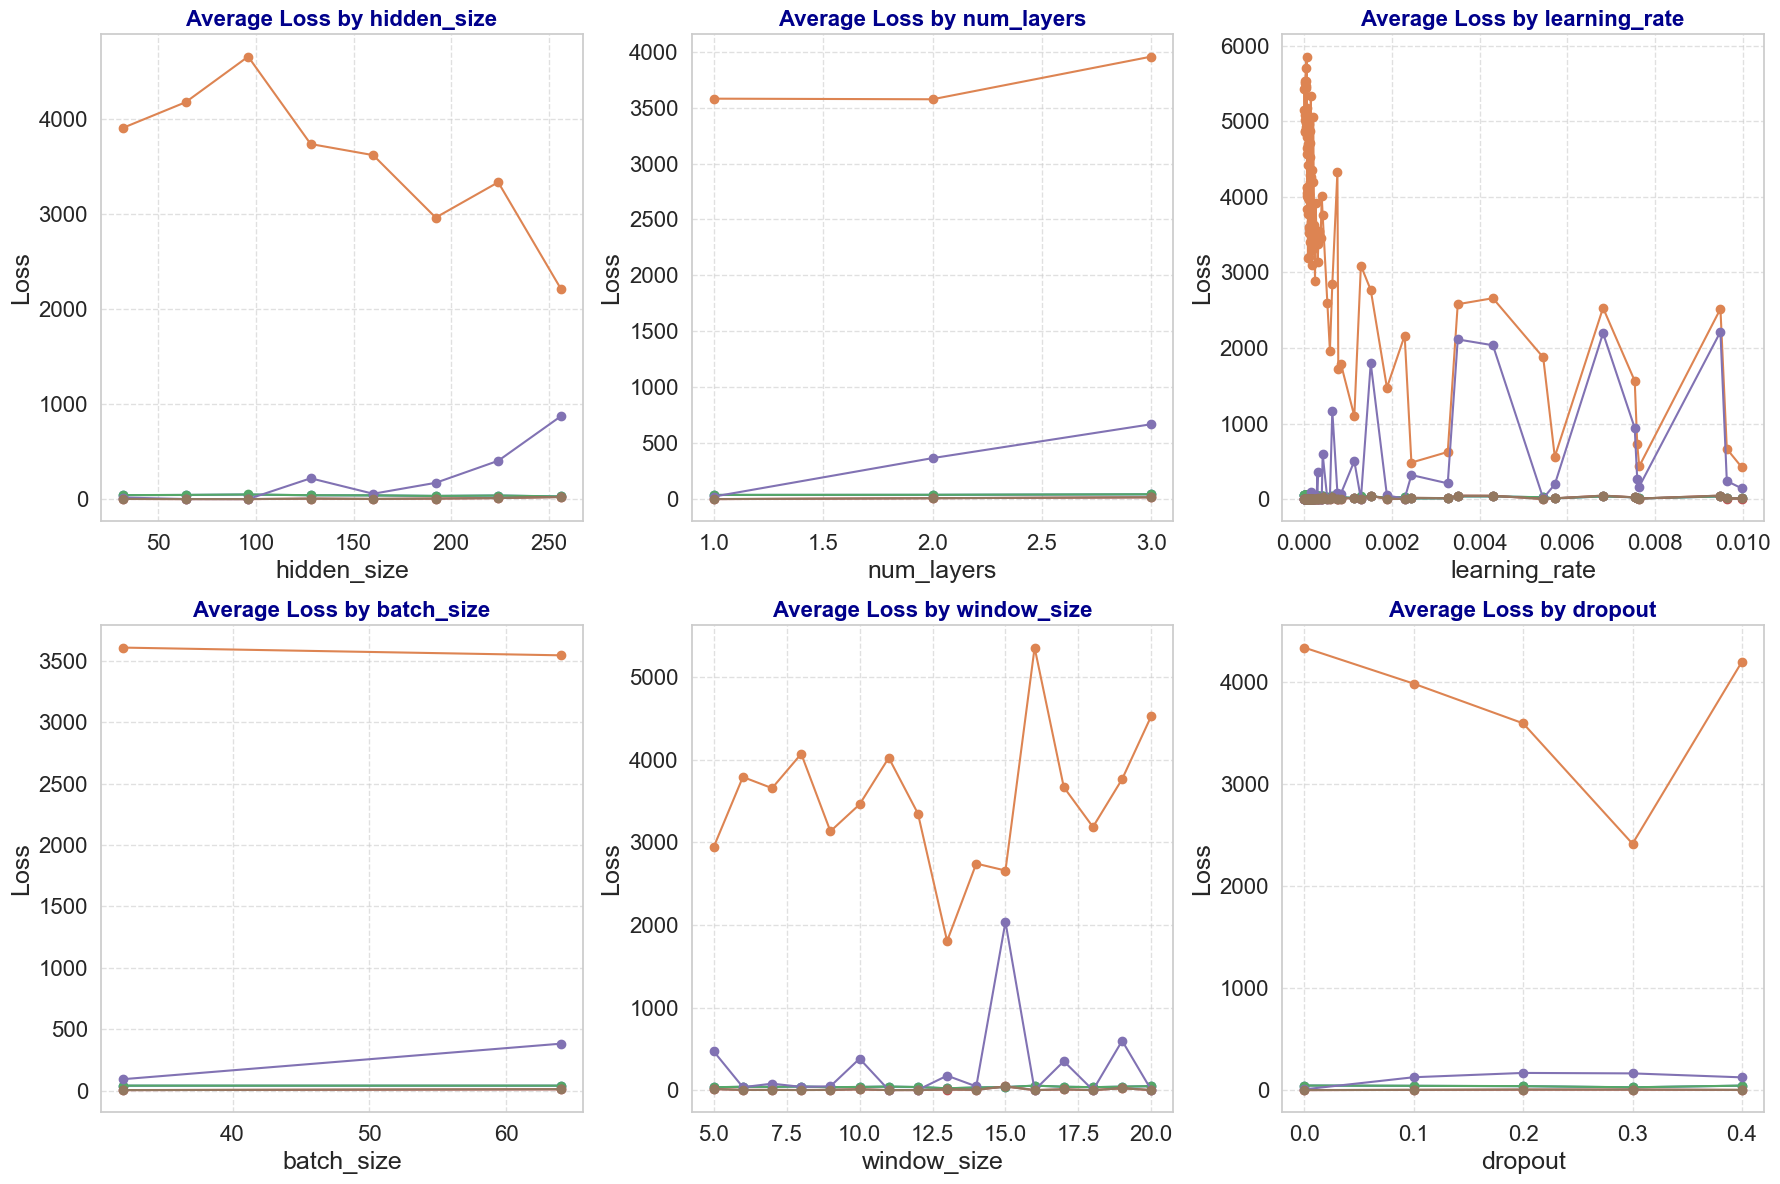

In [9]:
def plot_metrics_by_parameters(metrics_df, parameters, save_path="metrics_by_parameters.png"):
    """
    Create a single figure with subplots for each parameter, showing average losses.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing trial metrics and parameters.
        parameters (list): List of parameters to plot (e.g., ['hidden_size', 'num_layers', 'dropout']).
    """
    # Mapping loss types to more readable names
    loss_type_mapping = {
        "train_HuberLoss": "Train Huber Loss",
        "train_MSE": "Train MSE",
        "train_MAE": "Train MAE",
        "val_HuberLoss": "Validation Huber Loss",
        "val_MSE": "Validation MSE",
        "val_MAE": "Validation MAE"
    }

    num_params = len(parameters)
    ncols = 3  # Number of columns
    nrows = (num_params + ncols - 1) // ncols  # Dynamically calculate rows based on parameters
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 6 * nrows), sharex=False)

    # Flatten axes for easier iteration
    axes = axes.flatten()

    # Plot each parameter
    for i, (ax, parameter) in enumerate(zip(axes, parameters)):
        grouped = metrics_df.groupby(parameter).mean()  # Group by the parameter and calculate averages
        for loss, readable_name in loss_type_mapping.items():
            if loss in grouped.columns:
                ax.plot(grouped.index, grouped[loss], label=readable_name, marker='o', linestyle='-', linewidth=1.5)

        # Customize each subplot
        ax.set_xlabel(parameter, fontsize=18)
        ax.set_ylabel("Loss", fontsize=18)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.set_title(f"Average Loss by {parameter}", fontsize=16, weight='bold', color='darkblue')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Remove unused subplots if parameters < nrows * ncols
    for j in range(len(parameters), len(axes)):
        if j == len(parameters):  # Use the first unused subplot for the legend
            handles, labels = ax.get_legend_handles_labels()
            axes[j].legend(
                handles, labels, loc="center", fontsize=16, title="Loss Type", title_fontsize=20, frameon=False
            )
            axes[j].set_axis_off()  # Turn off the axis for the legend plot
        else:
            fig.delaxes(axes[j])  # Remove any additional unused subplots

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()

# Example: Plot average losses for all parameters in one figure
parameters_to_plot = ["hidden_size", "num_layers", "learning_rate", "batch_size", "window_size", "dropout"]
plot_metrics_by_parameters(all_metrics_df, parameters_to_plot)

### Predict the next 200 data points recursively

C:\Users\bar24\AppData\Local\Temp\ipykernel_33320\3432520654.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)


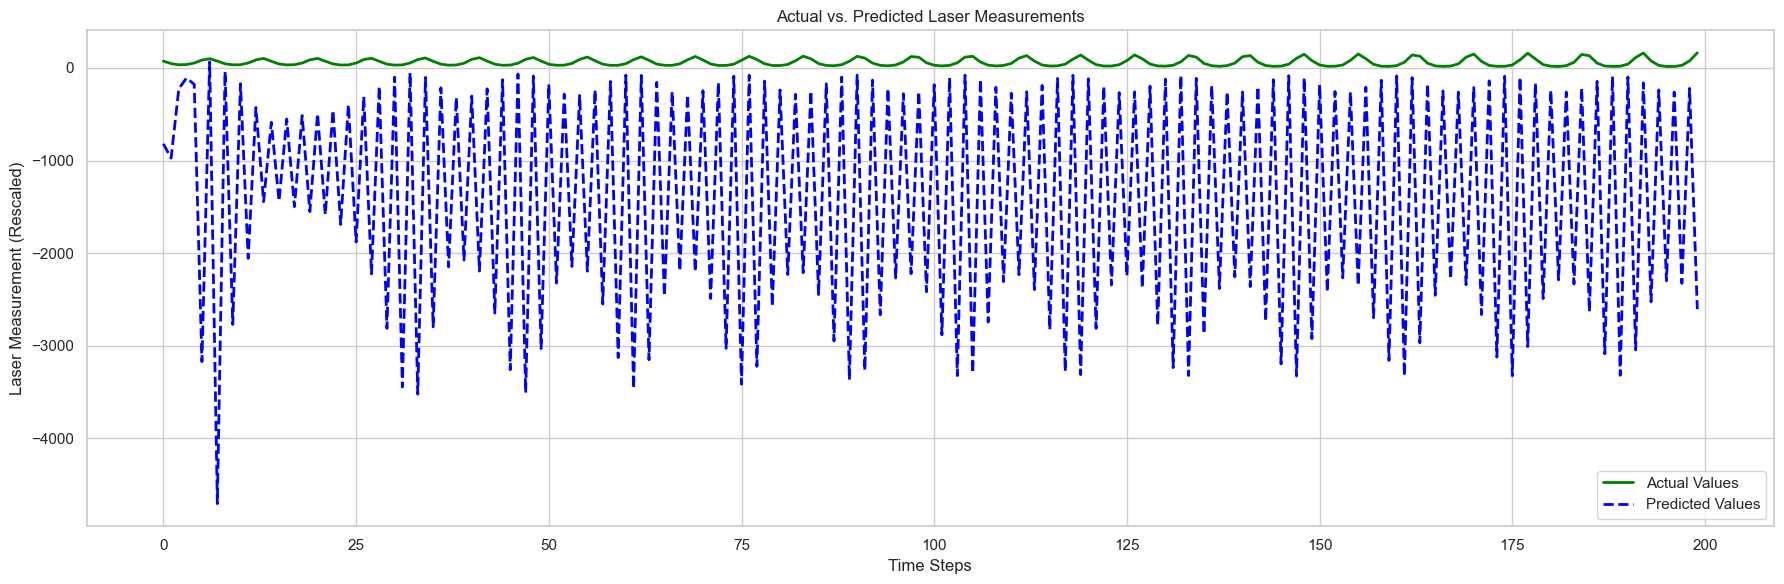

Metrics plot saved to actual_vs_predicted_plot.png


In [10]:
def predict_and_inverse_transform(model, init_window, scaler, steps=200):
    """
    Perform recursive forecasting using the trained model and convert predictions back to the original range.

    Args:
        model: The trained LSTM model.
        init_window: The initial sequence window (tensor) in normalized form.
        scaler: The MinMaxScaler used for normalization.
        steps: Number of forecasting steps.

    Returns:
        np.array: Forecasted values in the original range.
    """
    model.eval()
    preds = []
    current_seq = init_window.clone().to(device)  # Ensure the initial window is on the correct device

    with torch.no_grad():
        for step in range(steps):
            # Forward pass
            input = current_seq.unsqueeze(0).contiguous()  # Add batch dimension
            pred = model(input)  # shape: (1, seq_len, forecast_steps)

            # Extract the first predicted value
            pred_value = pred.item()  # Extract the first step of the forecast
            preds.append(pred_value)

            # Update the sequence by appending the prediction and removing the oldest value
            next_value = torch.tensor([[pred_value]], dtype=torch.float32, device=device)
            current_seq = torch.cat((current_seq[1:], next_value), dim=0)

    # Convert predictions to numpy array
    preds = np.array(preds).reshape(-1, 1)

    # Inverse transform the predictions to the original range
    preds_original = scaler.inverse_transform(preds)

    return preds_original

def plot_signals(predictions_rescaled, actual_values, save_path="actual_vs_predicted_plot.png"):
    """
    Plot training and validation metrics after training and compare predictions with actual values.
    """
    plt.figure(figsize=(18, 6))

    # Plot Actual vs Predicted Values
    plt.plot(actual_values, label="Actual Values", color="green", linewidth=2)
    plt.plot(predictions_rescaled, label="Predicted Values", color="blue", linestyle="--", linewidth=2)
    plt.xlabel("Time Steps")
    plt.ylabel("Laser Measurement (Rescaled)")
    plt.title("Actual vs. Predicted Laser Measurements")
    plt.legend()

    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    print(f"Metrics plot saved to {save_path}")
   
# Perform recursive forecasting to generate predictions
# Use the first sequence from the validation set as the initial window
init_window = torch.tensor(val_X[0], dtype=torch.float32).to(device)

# Predict and convert back to the original range
predicted_signal = predict_and_inverse_transform(best_model, init_window, scaler, steps=200)

# Compare with the actual values (also inverse transformed if needed)
actual_signal = scaler.inverse_transform(val_y[:len(predicted_signal)])

plot_signals(predicted_signal, actual_signal)

In [11]:
import torch.nn as nn

def evaluate_model_on_validation(best_model, val_loader):
    """
    Evaluate the best model on the validation dataset and calculate MSE and MAE using PyTorch loss functions.

    Args:
        best_model: The trained model.
        val_loader: The validation dataset (normalized).

    Returns:
        mse: Mean Squared Error.
        mae: Mean Absolute Error.
    """
    # Switch the model to evaluation mode
    best_model.eval()

    # Define PyTorch loss functions
    mse_criterion = nn.MSELoss()
    mae_criterion = nn.L1Loss()

    # Collect predictions and ground truth
    total_mse = 0.0
    total_mae = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch[0].to(device), batch[1].to(device)
            output = best_model(x_batch)

            # Calculate losses
            mse = mse_criterion(output, y_batch).item()
            mae = mae_criterion(output, y_batch).item()

            # Accumulate losses
            total_mse += mse * x_batch.size(0)
            total_mae += mae * x_batch.size(0)
            num_samples += x_batch.size(0)

    # Calculate average losses
    avg_mse = total_mse / num_samples
    avg_mae = total_mae / num_samples

    print(f"Validation MSE: {avg_mse}")
    print(f"Validation MAE: {avg_mae}")

    return avg_mse, avg_mae

# Evaluate the best model
mse, mae = evaluate_model_on_validation(best_model, val_loader)

Validation MSE: 53.79471079508463
Validation MAE: 7.327475767567324


### Load the trained model

In [ ]:
import json

def load_best_model():
    # Load the best hyperparameters
    with open(f"best_hyperparameters_{model_name}.json", "r") as f:
        best_params = json.load(f)

    # Recreate the model with the best hyperparameters
    best_model = LSTM(
        input_size=1,
        hidden_size=best_params["hidden_size"],
        num_stacked_layers=best_params["num_layers"]
    ).to(device)

    # Load the saved model weights
    best_model.load_state_dict(torch.load(model_pth_path))
    best_model.eval()

    return best_model, best_params

best_model, best_params = load_best_model()
print("Best hyperparameters are:", best_params)